# Simulation for Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [1]:
import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind
import matplotlib.pyplot as plt

In [2]:
# Stirling numbers of second kind
S = [[0 for i in range(1001)] for j in range(1001)]

# Combinations
C = [[0 for i in range(1001)] for j in range(1001)]

def stirling(n,k,S):
    if S[n][k] > 0: return S[n][k]
    if k>n or k==0 or n==0: return 0
    if k==1 or k==n:
        S[n][k]=1
    else:
        S[n][k] = stirling(n-1,k-1,S) + k*stirling(n-1,k,S)
    return S[n][k]

def P_exact_cols(n,k,cl,S):
#     if prt: print('n,k,cl',n,k,cl)
    p = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        p*=i
    p = p*stirling(cl,k,S)
    return p

def combs(n,k,C,S):
    if C[n][k] > 0: return C[n][k]
    if k>n or k==0 or n==0: return 0
    c = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        c*=i
    C[n][k] = c*stirling(n,k,S)
    return C[n][k]

def H(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors
def H_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += k * C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors squared
def H_t_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += (k**2) * C[n][k] * (z**k)
    return h

def E_cols(n,z,C):
    return H_t(n,z,C)/H(n,z,C)

def Var_cols(n,z,C):
    EX_2 = H_t_t(n,z,C)/H(n,z,C)
    v = EX_2 - (E_cols(n,z,C)**2)
#     if v < 0: print("Negative variance in",n,z,C)
    return v

def std_cols(n,z,C):
    return Var_cols(n,z,C)**(0.5)

In [3]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

session = WolframLanguageSession()

for i in range(1001):
    if i%100==0: print(i)
    for j in range(1001):
        stirling(i,j,S)
        combs(i,j,C,S)

0
100
200
300
400
500
600
700
800
900
1000


In [4]:
def plot_avg_std_colors (N):
    max_gamma = 15
    gammas = np.linspace(0, max_gamma, num=100)
    z = [np.e**(-gamma) for gamma in gammas]
    y = [E_cols(N,zz,C) for zz in z]
    yerr = [np.real(std_cols(N,zz,C)) for zz in z]
    f = plt.figure(figsize=(18, 5))
    plt.errorbar(gammas, y, yerr=yerr, marker='o', color='black', capsize=3)
    plt.xlabel("Gamma (g)") 
    plt.ylabel("Std. num. colors")
    plt.title(str(N) + " total sites / colors")
#     plt.savefig("Expected_no_colors/avg_std_(" + str(N)+","+str(N)+")_vary_gamma_.png", format="png")
    plt.show()

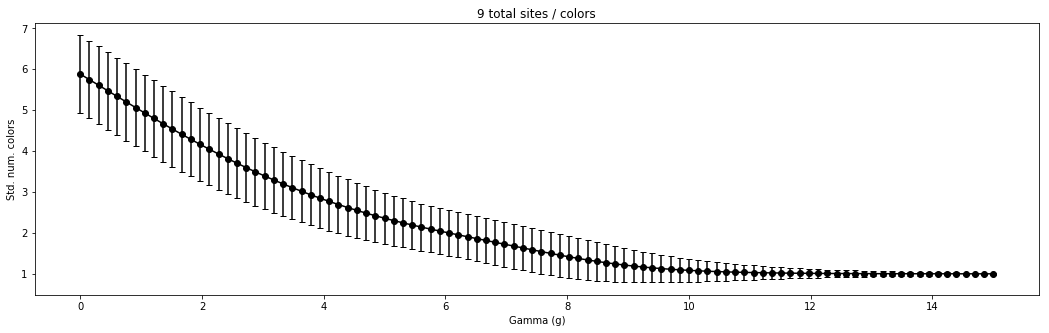

In [5]:
plot_avg_std_colors (9)

In [36]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/
# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(low=1, high=no_colors+1, size=(N,N))
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    if prt: print('current no. cols (lambda):', current_k)
    p = prob_lambda[current_k-1:]
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1)      
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]


def sample_config(config, eta, N, no_colors, sites, uf=None, cluster_constraints=None):
    
    if uf==None and not debugging:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        cluster_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.int8)
        for cluster in uf.components():
            cl_n += 1
            min_constraint = no_colors
            cluster_root = '-1,-1'
            for site_str in cluster:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    cluster_root = site_str
                cls[site[0],site[1]] = cl_n
            cluster_constraints[cluster_root] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    # Case with no field
    if alpha==0:
        '''Choose exactly how many colors to use in the configuration'''
        max_colors = eta[0] # eta_lambda
        prob_k = []
        if debugging:
            no_cl = N*N
        else:
            no_cl = len(uf.components())
        for k in range(1,max_colors+1):
            prob_k.append(P_exact_cols(no_colors,k,no_cl,S))
        if prt: print('prob_k:', prob_k)
        prob_k = [pk / sum(prob_k) for pk in prob_k]
        prob_k = np.array(prob_k)
        if prt: print('prob_k:', prob_k)
        exact_k = np.random.choice((np.arange(1, max_colors+1)), p=prob_k)
        if prt: print('exact number of colors to use in configuration:')
        if prt: print(exact_k)
            
        if debugging:
            chosen_colors = range(1,exact_k+1)
            if exact_k == no_colors:
                chosen_partition = [exact_k]
            else:
                chosen_partition = [exact_k-1] + [0]*max(0,no_colors-exact_k-1) + [1]
            if prt: print('chosen partition:')
            if prt: print(chosen_partition)
            part = []
            for i in range(len(chosen_partition)):
                part += ([i+1]*chosen_partition[i])
            chosen_partition = part
            if prt: print('chosen partition:')
            if prt: print(chosen_partition)
            color_arr = []
            for i in range(len(chosen_partition)):
                color_arr += [chosen_colors[i]]*chosen_partition[i]
            config = np.array(color_arr).reshape((N,N))
            return config, None, None

        '''Sample a partition of the no. of clusters into k using Bell polynomials'''
        session.evaluate("subs = Array[x,"+str(no_cl-exact_k+1)+"]")
        partition_dict = session.evaluate("Association@CoefficientRules[BellY["+str(no_cl)+", "+str(exact_k)+", subs],subs]")
        if prt: print("partition_dict", partition_dict)
        partitions = []
        partition_p = []
        for partition in partition_dict:
            partitions.append(partition)
            partition_p.append(partition_dict[partition])
        if prt: print('partition_p:', partition_p)
        partition_p = [pk / sum(partition_p) for pk in partition_p]
        parition_p = np.array(partition_p)
        if prt: print('partition_p:', partition_p)
        chosen_partition = partitions[np.random.choice((np.arange(0, len(partitions))), p=partition_p)]
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)
        # Transform to actual partition
        part = []
        for i in range(len(chosen_partition)):
            part += ([i+1]*chosen_partition[i])
        chosen_partition = part
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)

        '''Color each block in the partition randomly without replacement'''
        # Choose the colors to be used
        chosen_colors = np.random.choice((np.arange(1, no_colors+1)), len(chosen_partition), replace=False)
        # Choose a random permutation of the given word
        color_arr = []
        for i in range(len(chosen_partition)):
            color_arr += [chosen_colors[i]]*chosen_partition[i]
        color_arr = np.array(color_arr)
        color_arr = np.random.permutation(color_arr)
        if prt: print('colors for clusters:')
        if prt: print(color_arr)
        
        '''Color each cluster with the assigned color'''
        i=0
        for root in cluster_constraints:
            cluster_color = color_arr[i]
            for site_str in uf.component(root):
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            i+=1
    
    # Case with field
    else:
        '''Randomly sample a color for each cluster'''
        for root in cluster_constraints:
            max_col = cluster_constraints[root]
            cluster_color = np.random.choice((np.arange(1, max_col+1)))
            for site_str in uf.clusteronent(root):
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            
    return config, uf, cluster_constraints


def assign_labels(config, eta, N, no_colors, sites):
    '''Assign a color configuration chosen uniformly from the configurations clusteratible with eta'''
    # Brute force version
    max_colors = eta[0] # eta_lambda
    config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites)
    while number_of_colors(config) > max_colors:
        config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, uf, cluster_constraints)
        if prt: print('retrying sample (too many colors)')
    return config

## Experiment routine

In [49]:
# Small experiment

debugging = False
prt = True
N, no_cols = 3, 9
gamma = 0.12    # strength of preference for low no. of cols
J = 0.6      # strength of preference for bonds
alpha = 0  # strength of preference for colors (field)

'''Probabilities ordered from highest (high energy) to lowest'''
lambda_prob = np.zeros(no_cols)
for j in range(no_cols):
    lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
print('lambda probabilities:', lambda_prob)

edge_prob = np.zeros(2)
edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
print('edge probabilities:', edge_prob)

site_prob = np.zeros(no_cols)
for j in range(no_cols):
    site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
print('site probabilities:', site_prob)

eta_prob = (lambda_prob, edge_prob, site_prob)

'''Current states of eta'''
eta_lambda = 0
eta_edges = np.zeros((N,N,2), dtype=np.int8)
# Special edge cases (no neighbors at the border)
eta_edges[:,N-1,1] = -1
eta_edges[N-1,:,0] = -1
eta_sites = np.zeros((N,N), dtype=np.int8)
eta = [eta_lambda, eta_edges, eta_sites]

'''List of sites (tuples) for Union-Find'''
sites = []
for i in range(N):
    for j in range(N):
        sites.append(str(i)+','+str(j))

config = initial_config(N, no_cols)
print('\ninitial config:')
print(config)
for i in range(100):
    if prt: print('\n' + '-'*20 + ' iter ' + str(i) + ' ' + '-'*20)
    config = mc_move(config, eta_prob, eta, N, no_cols, sites)
    # if i%100 == 0: print(i)

print('\nfinal config:')
print(config)

session.terminate()

lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
edge probabilities: [0.69880579 0.30119421]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[7 3 6]
 [3 5 2]
 [4 3 5]]

-------------------- iter 0 --------------------
probabilities for no. of colors (lambda): [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
current no. cols (lambda): 6
assigned no. cols (eta_lambda): 9
probabilities for edges: [0.69880579 0.30119421]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
clusters formed by bonds (eta_edge):
[[1 2 3]
 [4 5 6]
 [7 8 9]]
prob_k: [9, 18360, 1524600, 23496480, 105099120, 160030080, 83825280, 13063680, 362880]
prob_k: [2.32305731e-08 4.73903692e-05 3.93525909e-0

partition_dict {(5,): 1}
partition_p: [1]
partition_p: [1.0]
chosen partition:
(5,)
chosen partition:
[1, 1, 1, 1, 1]
colors for clusters:
[1 4 2 6 5]
config:
[[1 1 1]
 [4 4 1]
 [2 6 5]]

-------------------- iter 15 --------------------
probabilities for no. of colors (lambda): [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
current no. cols (lambda): 5
assigned no. cols (eta_lambda): 9
probabilities for edges: [0.69880579 0.30119421]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]

[[ 0  0 -1]
 [ 0  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
clusters formed by bonds (eta_edge):
[[1 1 1]
 [2 2 3]
 [4 5 6]]
prob_k: [9, 2232, 45360, 196560, 226800, 60480, 0, 0, 0]
prob_k: [1.69350878e-05 4.19990178e-03 8.53528426e-02 3.69862318e-01
 4.26764213e-01 1.13803790e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
exact numb

assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
clusters formed by bonds (eta_edge):
[[1 1 1]
 [2 3 4]
 [2 5 6]]
prob_k: [9, 2232, 45360, 196560, 226800, 60480, 0, 0, 0]
prob_k: [1.69350878e-05 4.19990178e-03 8.53528426e-02 3.69862318e-01
 4.26764213e-01 1.13803790e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
exact number of colors to use in configuration:
5
partition_dict {(4, 1): 15}
partition_p: [15]
partition_p: [1.0]
chosen partition:
(4, 1)
chosen partition:
[1, 1, 1, 1, 2]
colors for clusters:
[9 5 3 7 2 2]
config:
[[9 9 9]
 [5 3 7]
 [5 2 2]]

-------------------- iter 28 --------------------
probabilities for no. of colors (lambda): [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
current no. cols (lambda): 5
assigned no. cols (eta_lambda): 8
probabilities for edges: [0.69880579 0.30119421]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]

[[ 0  0 -1]
 [ 1  1 -1]
 [ 1  0 -1]]
probabilities f

 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
clusters formed by bonds (eta_edge):
[[1 2 3]
 [4 5 6]
 [4 7 8]]
prob_k: [9, 9144, 486864, 5143824, 15876000, 16087680, 5080320, 362880, 0]
prob_k: [2.09075158e-07 2.12420361e-04 1.13101298e-02 1.19493980e-01
 3.68808579e-01 3.73726027e-01 1.18018745e-01 8.42991038e-03
 0.00000000e+00]
exact number of colors to use in configuration:
5
partition_dict {(4, 0, 0, 1): 70, (3, 1, 1, 0): 560, (2, 3, 0, 0): 420}
partition_p: [70, 560, 420]
partition_p: [0.06666666666666667, 0.5333333333333333, 0.4]
chosen partition:
(3, 1, 1, 0)
chosen partition:
[1, 1, 1, 2, 3]
colors for clusters:
[8 9 2 7 9 2 2 3]
config:
[[8 9 2]
 [7 9 2]
 [7 2 3]]

-------------------- iter 42 --------------------
probabilities for no. of colors (lambda): [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.382

config:
[[1 1 4]
 [2 8 8]
 [2 1 7]]

-------------------- iter 55 --------------------
probabilities for no. of colors (lambda): [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
current no. cols (lambda): 5
assigned no. cols (eta_lambda): 6
probabilities for edges: [0.69880579 0.30119421]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
clusters formed by bonds (eta_edge):
[[1 2 3]
 [4 5 6]
 [7 8 9]]
prob_k: [9, 18360, 1524600, 23496480, 105099120, 160030080]
prob_k: [3.10164452e-08 6.32735482e-05 5.25418582e-03 8.09752538e-02
 3.62200122e-01 5.51507134e-01]
exact number of colors to use in configuration:
6
partition_dict {(5, 0, 0, 1): 126, (4, 1, 1, 0): 1260, (3, 3, 0, 0): 1260}
partition_p: [126, 1260, 1260]
partition_p: [0.047619047619047616, 0.4761904761

partition_dict {(5, 0, 1): 56, (4, 2, 0): 210}
partition_p: [56, 210]
partition_p: [0.21052631578947367, 0.7894736842105263]
chosen partition:
(4, 2, 0)
chosen partition:
[1, 1, 1, 1, 2, 2]
colors for clusters:
[2 4 9 1 8 6 1 8]
config:
[[2 4 9]
 [1 8 6]
 [1 1 8]]

-------------------- iter 68 --------------------
probabilities for no. of colors (lambda): [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
current no. cols (lambda): 6
assigned no. cols (eta_lambda): 9
probabilities for edges: [0.69880579 0.30119421]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 0  1  1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 0  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
clusters formed by bonds (eta_edge):
[[1 2 3]
 [4 5 6]
 [4 4 7]]
prob_k: [9, 4536, 151704, 1058400, 2116800, 1270080, 181440, 0, 0]
prob_k: [1.88167642e-06 9.48364917e-04 3.17175378e-02 2.21285147e-01


partition_dict {(5, 1): 21}
partition_p: [21]
partition_p: [1.0]
chosen partition:
(5, 1)
chosen partition:
[1, 1, 1, 1, 1, 2]
colors for clusters:
[7 8 6 6 1 4 5]
config:
[[7 8 6]
 [6 8 8]
 [1 4 5]]

-------------------- iter 82 --------------------
probabilities for no. of colors (lambda): [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
current no. cols (lambda): 6
assigned no. cols (eta_lambda): 9
probabilities for edges: [0.69880579 0.30119421]
assigned bonds (eta_edges):
[[ 1  0  1]
 [ 1  1  1]
 [-1 -1 -1]]

[[ 1  1 -1]
 [ 1  1 -1]
 [ 1  1 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
clusters formed by bonds (eta_edge):
[[1 2 3]
 [4 2 5]
 [6 7 8]]
prob_k: [9, 9144, 486864, 5143824, 15876000, 16087680, 5080320, 362880, 0]
prob_k: [2.09075158e-07 2.12420361e-04 1.13101298e-02 1.19493980e-01
 3.68808579e-01 3.73726027e-01 1.18018745e-01 8.42991038e

exact number of colors to use in configuration:
5
partition_dict {(5,): 1}
partition_p: [1]
partition_p: [1.0]
chosen partition:
(5,)
chosen partition:
[1, 1, 1, 1, 1]
colors for clusters:
[8 9 7 2 5]
config:
[[8 8 9]
 [7 7 2]
 [7 5 5]]

-------------------- iter 96 --------------------
probabilities for no. of colors (lambda): [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
current no. cols (lambda): 5
assigned no. cols (eta_lambda): 9
probabilities for edges: [0.69880579 0.30119421]
assigned bonds (eta_edges):
[[ 1  1  1]
 [ 0  1  1]
 [-1 -1 -1]]

[[ 0  1 -1]
 [ 0  1 -1]
 [ 1  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[9 9 9]
 [9 9 9]
 [9 9 9]]
clusters formed by bonds (eta_edge):
[[1 1 2]
 [3 3 4]
 [3 5 5]]
prob_k: [9, 1080, 12600, 30240, 15120, 0, 0, 0, 0]
prob_k: [1.52415790e-04 1.82898948e-02 2.13382106e-01 5.12117055e-01
 2.56058528e-01 0.00000000e+00 0.00000000e+0

## Full simulation

In [41]:
'''Parameters'''
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation

In [42]:
def experiment_full_interaction_gamma (N, no_cols, gammas, J=1, alpha=1):
    '''Run simulation for different gammas given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    print('edge probabilities:', edge_prob)
    
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    print('site probabilities:', site_prob)
    
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(ngamma), np.zeros(ngamma)
    std_c, std_s_c = np.zeros(ngamma), np.zeros(ngamma)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter across the logspace'''
    print('Trying gammas:', gammas)
    for igamma in range(ngamma):
        
        '''Probabilities for the varying parameter'''
        gamma = gammas[igamma]
        lambda_prob = np.zeros(no_cols)
        for j in range(no_cols):
            lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
        print(igamma, ' - gamma:', gamma)
        print('lambda probabilities:', lambda_prob)
        
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
        print('Final configuration:')
        print(config)
        avg_c[igamma] = tot_c / (mc_steps)
        avg_s_c[igamma] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[igamma], avg_s_c[igamma])
        std_c[igamma] = np.std(no_cols_arr)
        std_s_c[igamma] = np.std(no_sites_arr)
        print('Final stds:', std_c[igamma], std_s_c[igamma])
        print('-'*120 + '\n')
    
    f = plt.figure(figsize=(18, 5)); # plot the calculated values 
    
    my_max_gamma = 15
    my_gammas = np.linspace(0, my_max_gamma, num=200)
    z = [np.e**(-my_gamma) for my_gamma in my_gammas]
    y = [E_cols(N*N,zz,C) for zz in z]
    yerr = [np.real(std_cols(N*N,zz,C)) for zz in z]
    plt.errorbar(my_gammas, y, yerr=yerr, marker='o', color='black', capsize=3)
    
    plt.errorbar(gammas, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    
    plt.title(str(N*N) + " total sites / colors", fontsize=20)
    plt.xlabel("Gamma (g)", fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.savefig("Simulation_all_interaction_vs_exp/avg_std_(" + str(N)+","+str(N)+")_J_"+str(J)+"_alpha_"+str(alpha)+"_vary_gamma_.png", format="png")
    
    plt.show()

edge probabilities: [0.69880579 0.30119421]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying gammas: [ 0.12  0.16  0.21  0.27  0.35  0.45  0.58  0.75  0.96  1.24  1.61  2.07
  2.68  3.46  4.46  5.76  7.44  9.6  12.39 16.  ]
0  - gamma: 0.12
lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
Initial configuration
[[4 1 3]
 [6 3 5]
 [1 6 9]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 2.25
101 num. cols: 4.217821782178218 avg. sites per col: 2.287340876944838
201 num. cols: 4.218905472636816 avg. sites per col: 2.2773987206823048
301 num. cols: 4.312292358803987 avg. sites per col: 2.23298528713811
401 num. cols: 4.448877805486284 avg. sites per col: 2.15701816886355
501 num. cols: 4.411177644710579 avg. sites per col: 2.175876817792978
601 num. cols: 4.470881863560732 av

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 2.25
101 num. cols: 4.336633663366337 avg. sites per col: 2.199080622347949
201 num. cols: 4.263681592039801 avg. sites per col: 2.3311300639658867
301 num. cols: 4.06312292358804 avg. sites per col: 2.555624110109159
401 num. cols: 4.022443890274314 avg. sites per col: 2.62230138938368
501 num. cols: 4.069860279441118 avg. sites per col: 2.5499572284003373
601 num. cols: 4.023294509151414 avg. sites per col: 2.549964345139048
701 num. cols: 4.019971469329529 avg. sites per col: 2.5401263501120783
801 num. cols: 4.0536828963795255 avg. sites per col: 2.5041198501872586
901 num. cols: 4.027746947835738 avg. sites per col: 2.5118994767718372
1001 num. cols: 4.030969030969031 avg. sites per col: 2.499521906664766
Final configuration:
[[8 8 6]
 [3 8 8]
 [8 8 8]]
Final averages: 4.026865671641791 2.5015138592750557
Final stds: 1.16

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 4.5
101 num. cols: 2.6732673267326734 avg. sites per col: 3.594059405940594
201 num. cols: 1.9751243781094527 avg. sites per col: 5.7388059701492535
301 num. cols: 1.850498338870432 avg. sites per col: 6.059800664451827
401 num. cols: 1.7955112219451372 avg. sites per col: 6.276807980049876
501 num. cols: 1.780439121756487 avg. sites per col: 6.269461077844311
601 num. cols: 1.8569051580698834 avg. sites per col: 5.921131447587355
701 num. cols: 1.7902995720399428 avg. sites per col: 6.1099857346647655
801 num. cols: 1.784019975031211 avg. sites per col: 6.073782771535581
901 num. cols: 1.7258601553829078 avg. sites per col: 6.268701442841288
1001 num. cols: 1.7532467532467533 avg. sites per col: 6.151948051948052
Final configuration:
[[9 9 9]
 [9 9 9]
 [9 9 9]]
Final averages: 1.7502487562189055 6.163283582089552
Final stds: 

1001 num. cols: 1.0 avg. sites per col: 9.0
Final configuration:
[[8 8 8]
 [8 8 8]
 [8 8 8]]
Final averages: 1.0 9.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - gamma: 16.0
lambda probabilities: [9.99999887e-01 1.12535162e-07 1.26641641e-14 1.42516392e-21
 1.60381071e-28 1.80485118e-35 2.03109243e-42 2.28569342e-49
 2.57220937e-56]
Initial configuration
[[6 4 5]
 [5 8 2]
 [9 7 2]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.0 avg. sites per col: 9.0
201 num. cols: 1.0 avg. sites per col: 9.0
301 num. cols: 1.0 avg. sites per col: 9.0
401 num. cols: 1.0 avg. sites per col: 9.0
501 num. cols: 1.0 avg. sites per col: 9.0
601 num. cols: 1.0 avg. sites per col: 9.0
701 num. cols: 1.0 avg. sites per col: 9.0
801 num. cols: 1.0 avg.

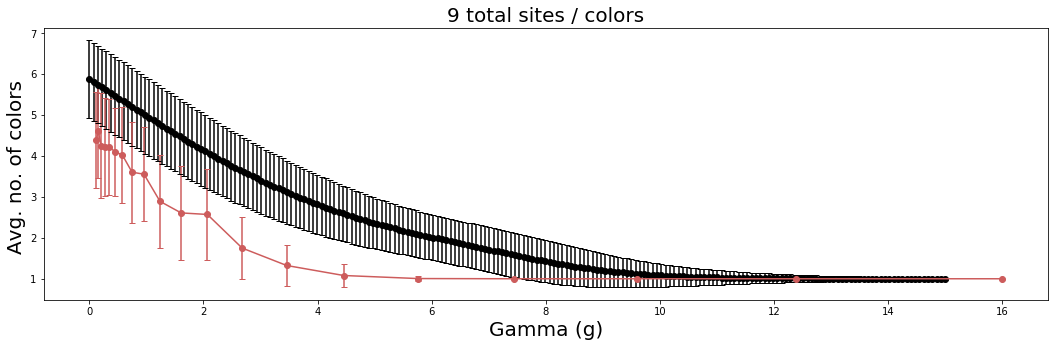

In [50]:
debugging  = False
prt = False
ngamma = 20
gammas = np.logspace(-3,4, base=2, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (3, 9, gammas, J=0.6, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying gammas: [ 0.12  0.16  0.21  0.27  0.35  0.45  0.58  0.75  0.96  1.24  1.61  2.07
  2.68  3.46  4.46  5.76  7.44  9.6  12.39 16.  ]
0  - gamma: 0.12
lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.38289289]
Initial configuration
[[3 5 3]
 [8 7 7]
 [1 2 7]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 6.0 avg. sites per col: 1.5
101 num. cols: 5.633663366336633 avg. sites per col: 1.631541725601132
201 num. cols: 5.741293532338308 avg. sites per col: 1.607356076759063
301 num. cols: 5.774086378737541 avg. sites per col: 1.604579971523494
401 num. cols: 5.7556109725685785 avg. sites per col: 1.6065016031350188
501 num. cols: 5.758483033932135 avg. sites per col: 1.6061163387510677
601 num. cols: 5.747088186356073 avg. sites per 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 2.25
101 num. cols: 5.3861386138613865 avg. sites per col: 1.7271216407355012
201 num. cols: 5.383084577114428 avg. sites per col: 1.727718550106611
301 num. cols: 5.382059800664452 avg. sites per col: 1.7294494542002863
401 num. cols: 5.3915211970074814 avg. sites per col: 1.728847524047024
501 num. cols: 5.385229540918163 avg. sites per col: 1.730089820359278
601 num. cols: 5.356073211314476 avg. sites per col: 1.746125505110525
701 num. cols: 5.370898716119829 avg. sites per col: 1.7395506419400777
801 num. cols: 5.33083645443196 avg. sites per col: 1.7544007490636606
901 num. cols: 5.341842397336293 avg. sites per col: 1.7499603615030803
1001 num. cols: 5.344655344655345 avg. sites per col: 1.749446981589826
Final configuration:
[[1 2 3]
 [4 5 6]
 [6 6 6]]
Final averages: 5.3462686567164175 1.7487526652451897
Final stds: 0

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 3.0
101 num. cols: 3.712871287128713 avg. sites per col: 2.613224893917965
201 num. cols: 3.7412935323383083 avg. sites per col: 2.540724946695098
301 num. cols: 3.6345514950166113 avg. sites per col: 2.5956336022781215
401 num. cols: 3.6433915211970076 avg. sites per col: 2.5857499109369417
501 num. cols: 3.684630738522954 avg. sites per col: 2.542985457656115
601 num. cols: 3.737104825291181 avg. sites per col: 2.50871167102448
701 num. cols: 3.7503566333808847 avg. sites per col: 2.4942734868555094
801 num. cols: 3.766541822721598 avg. sites per col: 2.482691278758691
901 num. cols: 3.8157602663706993 avg. sites per col: 2.4520374187410825
1001 num. cols: 3.825174825174825 avg. sites per col: 2.446389324960759
Final configuration:
[[1 2 3]
 [3 3 3]
 [3 3 3]]
Final averages: 3.8228855721393034 2.447846481876338
Final stds: 0

801 num. cols: 1.0 avg. sites per col: 9.0
901 num. cols: 1.0 avg. sites per col: 9.0
1001 num. cols: 1.0 avg. sites per col: 9.0
Final configuration:
[[1 1 1]
 [1 1 1]
 [1 1 1]]
Final averages: 1.0 9.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - gamma: 16.0
lambda probabilities: [9.99999887e-01 1.12535162e-07 1.26641641e-14 1.42516392e-21
 1.60381071e-28 1.80485118e-35 2.03109243e-42 2.28569342e-49
 2.57220937e-56]
Initial configuration
[[7 7 7]
 [8 3 7]
 [7 5 1]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.0 avg. sites per col: 9.0
201 num. cols: 1.0 avg. sites per col: 9.0
301 num. cols: 1.0 avg. sites per col: 9.0
401 num. cols: 1.0 avg. sites per col: 9.0
501 num. cols: 1.0 avg. sites per col: 9.0
601 num. cols: 1.0 avg.

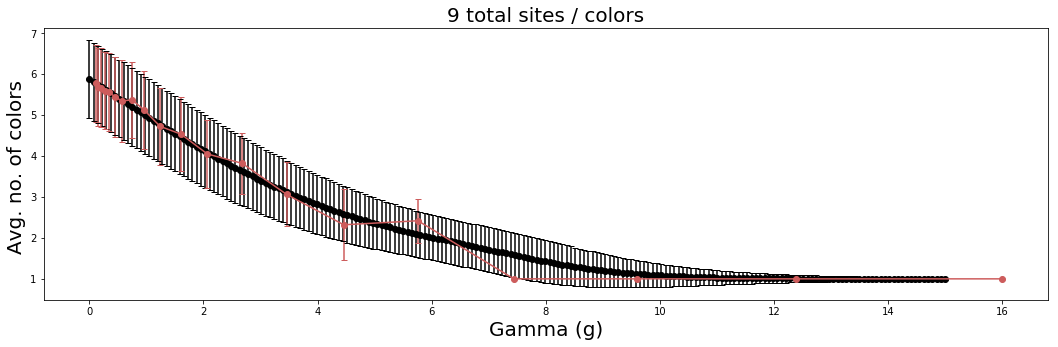

In [43]:
debugging  = True
prt = False
ngamma = 20
gammas = np.logspace(-3,4, base=2, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (3, 9, gammas, J=0, alpha=0)

edge probabilities: [0.69880579 0.30119421]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying gammas: [ 0.12  0.16  0.21  0.27  0.35  0.45  0.58  0.75  0.96  1.24  1.61  2.07
  2.68  3.46  4.46  5.76  7.44  9.6  12.39 16.  ]
0  - gamma: 0.12
lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.04329736 0.03840131 0.03405891 0.03020754
 0.02679169 0.0237621  0.02107509 0.16529889]
Initial configuration
[[ 9 15  4  2]
 [15 15  9  4]
 [ 8  5 16 15]
 [16  4 16  9]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 2.2857142857142856
101 num. cols: 8.821782178217822 avg. sites per col: 1.8598717014558581
201 num. cols: 8.875621890547263 avg. sites per col: 1.8487398726204678
301 num. cols: 8.787375415282392 avg. sites per col: 1.8655512077438994
401 num. cols: 8.7980049875

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 3.2
101 num. cols: 7.792079207920792 avg. sites per col: 2.124606746388923
201 num. cols: 7.955223880597015 avg. sites per col: 2.0840070929623167
301 num. cols: 8.13953488372093 avg. sites per col: 2.032353914081494
401 num. cols: 8.24438902743142 avg. sites per col: 2.001060839963594
501 num. cols: 8.231536926147704 avg. sites per col: 2.007698311889942
601 num. cols: 8.206322795341098 avg. sites per col: 2.0127272247072696
701 num. cols: 8.185449358059914 avg. sites per col: 2.016746227302585
801 num. cols: 8.099875156054932 avg. sites per col: 2.0392208152507854
901 num. cols: 8.134295227524973 avg. sites per col: 2.0292505619919674
1001 num. cols: 8.075924075924076 avg. sites per col: 2.043613884173331
Final configuration:
[[15 15  2  7]
 [13 10 10  9]
 [10 10 10 13]
 [13 16 10  1]]
Final averages: 8.07860696517413 2.0427

301 num. cols: 5.813953488372093 avg. sites per col: 2.9391551969625134
401 num. cols: 5.788029925187033 avg. sites per col: 2.9755294303922826
501 num. cols: 5.7684630738522955 avg. sites per col: 2.9873586161011403
601 num. cols: 5.747088186356073 avg. sites per col: 2.9758127987745424
701 num. cols: 5.723252496433666 avg. sites per col: 2.974154835495789
801 num. cols: 5.760299625468165 avg. sites per col: 2.9436696193250453
901 num. cols: 5.7014428412874585 avg. sites per col: 3.027923118933104
1001 num. cols: 5.766233766233766 avg. sites per col: 2.9976880262594463
Final configuration:
[[ 2  2  2  6]
 [ 2 12  2  2]
 [ 2  8  8  8]
 [ 2  8  8  8]]
Final averages: 5.7621890547263686 2.9992892679459753
Final stds: 1.4809446978497058 0.9375727900811919
------------------------------------------------------------------------------------------------------------------------

11  - gamma: 2.07
lambda probabilities: [8.73814218e-01 1.10262930e-01 1.39136140e-02 1.75570026e-03
 2.21544410e-0

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.2238805970149254 avg. sites per col: 14.208955223880597
301 num. cols: 1.4817275747508305 avg. sites per col: 12.146179401993356
401 num. cols: 1.399002493765586 avg. sites per col: 12.807980049875312
501 num. cols: 1.3193612774451098 avg. sites per col: 13.445109780439122
601 num. cols: 1.2662229617304492 avg. sites per col: 13.870216306156406
701 num. cols: 1.2282453637660484 avg. sites per col: 14.174037089871613
801 num. cols: 1.1997503121098627 avg. sites per col: 14.401997503121098
901 num. cols: 1.1775804661487237 avg. sites per col: 14.57935627081021
1001 num. cols: 1.1598401598401598 avg. sites per col: 14.721278721278722
Final configuration:
[[6 6 6 6]
 [6 6 6 6]
 [6 6 6 6]
 [6 6 6 6]]
Final averages: 1.1592039800995024 14.72636815920398
Final stds: 0.

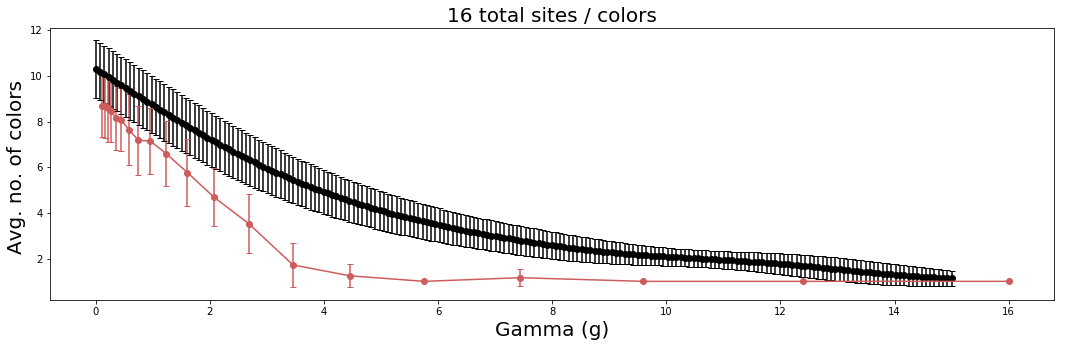

In [51]:
debugging  = False
prt = False
ngamma = 20
gammas = np.logspace(-3,4, base=2, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (4, 16, gammas, J=0.6, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying gammas: [ 0.12  0.16  0.21  0.27  0.35  0.45  0.58  0.75  0.96  1.24  1.61  2.07
  2.68  3.46  4.46  5.76  7.44  9.6  12.39 16.  ]
0  - gamma: 0.12
lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.04329736 0.03840131 0.03405891 0.03020754
 0.02679169 0.0237621  0.02107509 0.16529889]
Initial configuration
[[11  3  8  1]
 [ 4 12 13 16]
 [ 6 13 14  4]
 [ 2  6 13  8]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 10.0 avg. sites per col: 1.6
101 num. cols: 10.198019801980198 avg. sites per col: 1.5909362364807902
201 num. cols: 10.139303482587065 avg. sites per col: 1.5996905250636588
301 num. cols: 10.056478405315614 avg. sites per col: 1.6132708930051116
401 num. cols: 10.174563591022444 avg. sites per col: 

equilibration step: 4000
equilibration step: 5000
1 num. cols: 8.0 avg. sites per col: 2.0
101 num. cols: 9.366336633663366 avg. sites per col: 1.7457460031717442
201 num. cols: 9.611940298507463 avg. sites per col: 1.6980081278588746
301 num. cols: 9.704318936877076 avg. sites per col: 1.6789760258198803
401 num. cols: 9.71072319201995 avg. sites per col: 1.676083849649943
501 num. cols: 9.666666666666666 avg. sites per col: 1.6844324892229217
601 num. cols: 9.608985024958402 avg. sites per col: 1.6948541567510116
701 num. cols: 9.594864479315264 avg. sites per col: 1.6977693411359736
801 num. cols: 9.627965043695381 avg. sites per col: 1.6924987067309274
901 num. cols: 9.618201997780243 avg. sites per col: 1.6931896812030067
1001 num. cols: 9.61038961038961 avg. sites per col: 1.695394227262364
Final configuration:
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 10 10]
 [10 10 10 10]]
Final averages: 9.61094527363184 1.6951914420571186
Final stds: 1.2683987641375725 0.23513718470395273
-------

601 num. cols: 7.550748752079867 avg. sites per col: 2.18091732634163
701 num. cols: 7.621968616262482 avg. sites per col: 2.162853725763864
801 num. cols: 7.627965043695381 avg. sites per col: 2.1594615677012774
901 num. cols: 7.69700332963374 avg. sites per col: 2.137733767034552
1001 num. cols: 7.701298701298701 avg. sites per col: 2.134211531614134
Final configuration:
[[1 2 3 4]
 [5 6 7 8]
 [8 8 8 8]
 [8 8 8 8]]
Final averages: 7.708457711442786 2.132483326513182
Final stds: 1.2042950124730234 0.37298992652511653
------------------------------------------------------------------------------------------------------------------------

11  - gamma: 2.07
lambda probabilities: [8.73814218e-01 1.10262930e-01 1.39136140e-02 1.75570026e-03
 2.21544410e-04 2.79557546e-05 3.52761875e-06 4.45135329e-07
 5.61697495e-08 7.08782374e-09 8.94382580e-10 1.12858365e-10
 1.42411210e-11 1.79702699e-12 2.26759255e-13 3.27458552e-14]
Initial configuration
[[ 1  3  1  3]
 [10 14 14  7]
 [13 16 15 14]
 [

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 2.0 avg. sites per col: 8.0
201 num. cols: 2.0 avg. sites per col: 8.0
301 num. cols: 2.1362126245847177 avg. sites per col: 7.6367663344407735
401 num. cols: 2.3516209476309227 avg. sites per col: 7.062344139650926
501 num. cols: 2.4810379241516967 avg. sites per col: 6.717232202262215
601 num. cols: 2.56738768718802 avg. sites per col: 6.486966167498699
701 num. cols: 2.7004279600570613 avg. sites per col: 6.2272943414171
801 num. cols: 2.8626716604244695 avg. sites per col: 5.9492301290054765
901 num. cols: 2.9889012208657046 avg. sites per col: 5.732889382168021
1001 num. cols: 3.0899100899100898 avg. sites per col: 5.559773559773613
Final configuration:
[[1 2 3 4]
 [4 4 4 4]
 [4 4 4 4]
 [4 4 4 4]]
Final averages: 3.093532338308458 5.5535655058043645
Final stds: 0.7760135149096263 1.5547959829632907
----

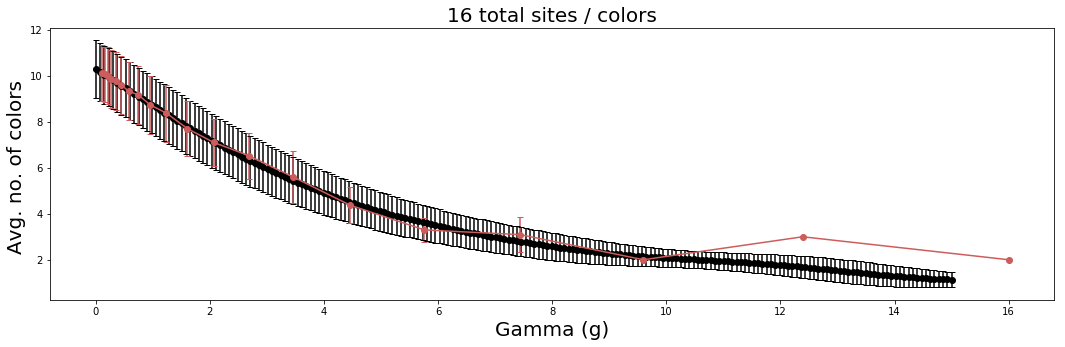

In [44]:
debugging  = True
prt = False
ngamma = 20
gammas = np.logspace(-3,4, base=2, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (4, 16, gammas, J=0, alpha=0)

edge probabilities: [0.69880579 0.30119421]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying gammas: [ 0.12  0.16  0.21  0.27  0.35  0.45  0.58  0.75  0.96  1.24  1.61  2.07
  2.68  3.46  4.46  5.76  7.44  9.6  12.39 16.  ]
0  - gamma: 0.12
lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.04329736 0.03840131 0.03405891 0.03020754
 0.02679169 0.0237621  0.02107509 0.01869193 0.01657825 0.01470359
 0.01304091 0.01156625 0.01025835 0.00909834 0.0080695  0.00715701
 0.05613476]
Initial configuration
[[ 6 18 15 11 13]
 [13 12  2 17 23]
 [10 22 19  6 11]
 [ 1 15 16 21  9]
 [ 3 15  3  1 21]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 12.0 avg. sites per col: 2.0833333333333335
101 num. cols: 13.841584158415841 avg. sites per col: 1.83941703397877
201 num. col

701 num. cols: 13.761768901569187 avg. sites per col: 1.8464263077208205
801 num. cols: 13.786516853932584 avg. sites per col: 1.8423301088992279
901 num. cols: 13.782463928967813 avg. sites per col: 1.8428223774568786
1001 num. cols: 13.728271728271729 avg. sites per col: 1.8501584206979762
Final configuration:
[[22 11 15  2  8]
 [ 6  2 19  5  5]
 [11  1 20  2  6]
 [ 9 20 10  3  4]
 [15 10 13  4  4]]
Final averages: 13.730348258706467 1.8498347260014871
Final stds: 1.6744864448063626 0.24273237595635522
------------------------------------------------------------------------------------------------------------------------

5  - gamma: 0.45
lambda probabilities: [3.62371848e-01 2.31058492e-01 1.47329399e-01 9.39413724e-02
 5.98996637e-02 3.81937118e-02 2.43533859e-02 1.55284044e-02
 9.90134781e-03 6.31337810e-03 4.02558761e-03 2.56682799e-03
 1.63668178e-03 1.04359438e-03 6.65425156e-04 4.24293812e-04
 2.70541679e-04 1.72504991e-04 1.09994039e-04 7.01352955e-05
 4.47202388e-05 2.851488

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 2.7777777777777777
101 num. cols: 11.099009900990099 avg. sites per col: 2.3016614848298045
201 num. cols: 11.27363184079602 avg. sites per col: 2.2601548534384306
301 num. cols: 11.408637873754152 avg. sites per col: 2.2393389648373
401 num. cols: 11.246882793017456 avg. sites per col: 2.2736934200462855
501 num. cols: 11.06187624750499 avg. sites per col: 2.3119689830019166
601 num. cols: 10.9783693843594 avg. sites per col: 2.327489424515213
701 num. cols: 11.018544935805991 avg. sites per col: 2.3230128169500475
801 num. cols: 11.0187265917603 avg. sites per col: 2.3261036369650565
901 num. cols: 10.895671476137625 avg. sites per col: 2.3558674030372107
1001 num. cols: 10.854145854145854 avg. sites per col: 2.364061942608401
Final configuration:
[[13 17  4  4 13]
 [ 4  4  4  2 13]
 [24 24  6  2  7]
 [23  8 10 20  7]
 [ 2  

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 4.782178217821782 avg. sites per col: 5.404290429042901
201 num. cols: 4.1840796019900495 avg. sites per col: 6.260364842454385
301 num. cols: 3.707641196013289 avg. sites per col: 7.295127353266863
401 num. cols: 3.3316708229426433 avg. sites per col: 8.385286783042382
501 num. cols: 3.3333333333333335 avg. sites per col: 8.486360612109122
601 num. cols: 2.945091514143095 avg. sites per col: 11.234054353854692
701 num. cols: 2.723252496433666 avg. sites per col: 12.502377555872567
801 num. cols: 2.561797752808989 avg. sites per col: 13.46441947565544
901 num. cols: 2.3995560488346284 avg. sites per col: 14.605993340732528
1001 num. cols: 2.306693306693307 avg. sites per col: 15.057442557442565
Final configuration:
[[ 4 10 10 10 10]
 [16 16 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10  4]]
Fi

601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[11 11 11 11 11]
 [11 11 11 11 11]
 [11 11 11 11 11]
 [11 11 11 11 11]
 [11 11 11 11 11]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------



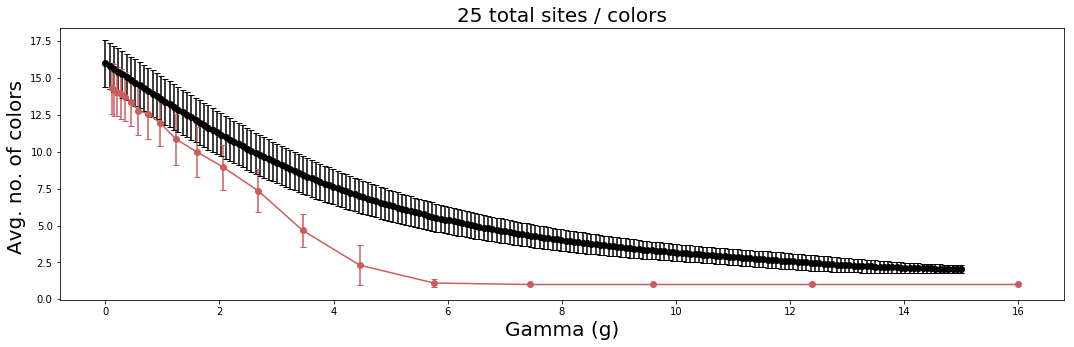

In [52]:
debugging  = False
prt = False
ngamma = 20
gammas = np.logspace(-3,4, base=2, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (5, 25, gammas, J=0.6, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying gammas: [ 0.12  0.16  0.21  0.27  0.35  0.45  0.58  0.75  0.96  1.24  1.61  2.07
  2.68  3.46  4.46  5.76  7.44  9.6  12.39 16.  ]
0  - gamma: 0.12
lambda probabilities: [0.11307956 0.10029258 0.08895153 0.07889293 0.06997176 0.06205938
 0.05504173 0.04881764 0.04329736 0.03840131 0.03405891 0.03020754
 0.02679169 0.0237621  0.02107509 0.01869193 0.01657825 0.01470359
 0.01304091 0.01156625 0.01025835 0.00909834 0.0080695  0.00715701
 0.05613476]
Initial configuration
[[19  1 12  8 22]
 [ 8 17  4 22  8]
 [19 21 18 17  5]
 [ 4  3  6  5  7]
 [18  4 20  8 25]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 18.0 avg. sites per col: 1.3888888888888888
101 num. cols: 15.178217821782178 avg. sites per col: 1.662525294223022
201 num. cols: 15.492537313

701 num. cols: 14.952924393723253 avg. sites per col: 1.6916988856373354
801 num. cols: 14.872659176029963 avg. sites per col: 1.702023253152503
901 num. cols: 14.849056603773585 avg. sites per col: 1.7045039473367736
1001 num. cols: 14.883116883116884 avg. sites per col: 1.700688318443629
Final configuration:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 18 18]
 [18 18 18 18 18]]
Final averages: 14.887562189054727 1.7001998655110813
Final stds: 1.6385573461068674 0.19251982498630216
------------------------------------------------------------------------------------------------------------------------

5  - gamma: 0.45
lambda probabilities: [3.62371848e-01 2.31058492e-01 1.47329399e-01 9.39413724e-02
 5.98996637e-02 3.81937118e-02 2.43533859e-02 1.55284044e-02
 9.90134781e-03 6.31337810e-03 4.02558761e-03 2.56682799e-03
 1.63668178e-03 1.04359438e-03 6.65425156e-04 4.24293812e-04
 2.70541679e-04 1.72504991e-04 1.09994039e-04 7.01352955e-05
 4.47202388e-05 2.85148832

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 10.0 avg. sites per col: 2.5
101 num. cols: 13.029702970297029 avg. sites per col: 1.9402387677358566
201 num. cols: 13.218905472636816 avg. sites per col: 1.9135075083275233
301 num. cols: 13.222591362126245 avg. sites per col: 1.9147580293026825
401 num. cols: 13.16708229426434 avg. sites per col: 1.9239389416428432
501 num. cols: 13.179640718562874 avg. sites per col: 1.9222541927499668
601 num. cols: 13.234608985024959 avg. sites per col: 1.9134062984691813
701 num. cols: 13.146932952924393 avg. sites per col: 1.9277619524378302
801 num. cols: 13.173533083645443 avg. sites per col: 1.9236269435239386
901 num. cols: 13.18534961154273 avg. sites per col: 1.9211413509415614
1001 num. cols: 13.166833166833166 avg. sites per col: 1.9246471593021977
Final configuration:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 13 13]
 [13 13 13 13 13]
 [13 13 13 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 3.5714285714285716
101 num. cols: 7.0 avg. sites per col: 3.5714285714285703
201 num. cols: 7.08955223880597 avg. sites per col: 3.5314498933901852
301 num. cols: 7.059800664451827 avg. sites per col: 3.5447318462268576
401 num. cols: 7.029925187032419 avg. sites per col: 3.5602956893480786
501 num. cols: 6.908183632734531 avg. sites per col: 3.636180020910592
601 num. cols: 6.590682196339435 avg. sites per col: 3.863105142223305
701 num. cols: 6.36376604850214 avg. sites per col: 4.025287004958924
801 num. cols: 6.262172284644195 avg. sites per col: 4.089753879079731
901 num. cols: 6.307436182019978 avg. sites per col: 4.054027271285866
1001 num. cols: 6.362637362637362 avg. sites per col: 4.014140621283459
Final configuration:
[[1 2 3 4 5]
 [6 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]]
Final averages: 6.365174129353234

equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 8.333333333333334
101 num. cols: 3.0 avg. sites per col: 8.333333333333343
201 num. cols: 3.0 avg. sites per col: 8.333333333333313
301 num. cols: 3.0 avg. sites per col: 8.333333333333337
401 num. cols: 3.0 avg. sites per col: 8.333333333333373
501 num. cols: 3.0 avg. sites per col: 8.333333333333387
601 num. cols: 3.0 avg. sites per col: 8.333333333333329
701 num. cols: 3.0 avg. sites per col: 8.333333333333286
801 num. cols: 3.0 avg. sites per col: 8.333333333333254
901 num. cols: 3.0 avg. sites per col: 8.33333333333323
1001 num. cols: 3.0 avg. sites per col: 8.333333333333226
Final configuration:
[[1 2 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]
 [3 3 3 3 3]]
Final averages: 3.0 8.33333333333323
Final stds: 0.0 1.7763568394002505e-15
------------------------------------------------------------------------------------------------------------------------



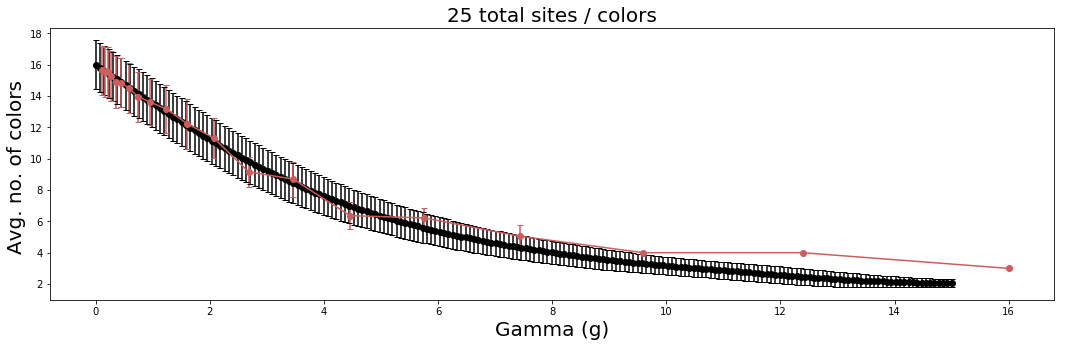

In [45]:
debugging = True
prt = False
ngamma = 20
gammas = np.logspace(-3,4, base=2, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (5, 25, gammas, J=0, alpha=0)

In [60]:
def init_edge_prob (J):
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    return edge_prob
    
def init_site_prob (alpha, no_cols):
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    return site_prob

def init_lambda_prob (gamma, no_cols):
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    return lambda_prob

In [104]:
def experiment_full_interaction (N, no_cols, gamma=0, J=0, alpha=0, gammas=None, Js=None, alphas=None):
    '''Run simulation for different parameters given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Identify varying parameter'''
    params = None
    param_name = "None"
    for pms,pname in [(gammas,"Gamma"), (Js,"J"), (alphas,"Alpha")]:
        if pms is not None:
            params = pms
            param_name = pname
    nparam = len(params)
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = init_edge_prob(J)
    site_prob = init_site_prob(alpha, no_cols)   
    lambda_prob = init_lambda_prob(gamma, no_cols)
    print('edge probabilities:', edge_prob)
    print('site probabilities:', site_prob)
    print('lambda probabilities:', lambda_prob)
    
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(nparam), np.zeros(nparam)
    std_c, std_s_c = np.zeros(nparam), np.zeros(nparam)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter across the logspace'''
    print('Trying params:', params)
    for iparam in range(nparam):
        
        '''Probabilities for the varying parameter'''
        param = params[iparam]
        print(iparam, ' - param:', param)
        if param_name=="Gamma":
            lambda_prob = init_lambda_prob(param, no_cols)
            print('lambda probabilities:', lambda_prob)
        elif param_name=="Alpha":
            site_prob = init_site_prob(param, no_cols)
            print('site probabilities:', site_prob)
        elif param_name=="J":
            edge_prob = init_edge_prob(param)
            print('edge probabilities:', edge_prob)
            
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
        print('Final configuration:')
        print(config)
        avg_c[iparam] = tot_c / (mc_steps)
        avg_s_c[iparam] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[iparam], avg_s_c[iparam])
        std_c[iparam] = np.std(no_cols_arr)
        std_s_c[iparam] = np.std(no_sites_arr)
        print('Final stds:', std_c[iparam], std_s_c[iparam])
        print('-'*120 + '\n')
    
    f = plt.figure(figsize=(18, 5)); # plot the calculated values 
    
    if param_name=="Gamma":
        my_max_gamma = gammas[-1]
        my_gammas = np.linspace(0, my_max_gamma, num=200)
        z = [np.e**(-my_gamma) for my_gamma in my_gammas]
        y = [E_cols(N*N,zz,C) for zz in z]
        yerr = [np.real(std_cols(N*N,zz,C)) for zz in z]
        plt.errorbar(my_gammas, y, yerr, marker='o', color='black', capsize=3)
    
    plt.errorbar(params, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    
    plt.title(str(N*N) + " total sites / colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(no_cols)
                + ")_J_" + str(J) + "_alpha_" + str(alpha) + "_gamma_" + str(gamma)
                + "_vary_" + param_name + "_.png", format="png")
    
    plt.show()

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 1.]
Initial configuration
[[4 4]
 [1 4]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 2.0
101 num. cols: 2.6732673267326734 avg. sites per col: 1.6105610561056107
201 num. cols: 2.7064676616915424 avg. sites per col: 1.5804311774461028
301 num. cols: 2.691029900332226 avg. sites per col: 1.6024363233665528
401 num. cols: 2.71072319201995 avg. sites per col: 1.5968412302576906
501 num. cols: 2.720558882235529 avg. sites per col: 1.5874916833000723
601 num. cols: 2.7437603993344424 avg. sites per col: 1.5734886300610178
701 num. cols: 2.7446504992867333 avg. sites per col:

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 2.0
101 num. cols: 1.702970297029703 avg. sites per col: 2.6732673267326734
201 num. cols: 1.8756218905472637 avg. sites per col: 2.4278606965174108
301 num. cols: 1.717607973421927 avg. sites per col: 2.688815060908083
401 num. cols: 1.7007481296758105 avg. sites per col: 2.6982543640897743
501 num. cols: 1.7325349301397206 avg. sites per col: 2.6387225548902173
601 num. cols: 1.7903494176372712 avg. sites per col: 2.536882972823069
701 num. cols: 1.8330955777460771 avg. sites per col: 2.4555397051830674
801 num. cols: 1.7815230961298376 avg. sites per col: 2.5584685809404863
901 num. cols: 1.7291897891231964 avg. sites per col: 2.6526082130965554
1001 num. cols: 1.7072927072927073 avg. sites per col: 2.6959706959706935
Final configuration:
[[1 1]
 [1 1]]
Final averages: 1.7044776119402985 2.70116086235489
Final stds: 0.6110343980238973 1.0283562700375362
-------------------

801 num. cols: 1.0699126092384519 avg. sites per col: 3.8601747815230962
901 num. cols: 1.0865704772475027 avg. sites per col: 3.8268590455049947
1001 num. cols: 1.077922077922078 avg. sites per col: 3.844155844155844
Final configuration:
[[1 1]
 [1 1]]
Final averages: 1.0776119402985074 3.8447761194029852
Final stds: 0.2675599503318992 0.5351199006637984
------------------------------------------------------------------------------------------------------------------------

13  - param: 5.57
lambda probabilities: [9.96189520e-01 3.79596067e-03 1.44644339e-05 5.53272657e-08]
Initial configuration
[[1 1]
 [3 1]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 4.0
101 num. cols: 1.0 avg. sites per col: 4.0
201 num. cols: 1.0 avg. sites per col: 4.0
301 num. cols: 1.0 avg. sites per col: 4.0
401 num. cols: 1.0 avg. sites per col: 4.0
501 num. cols: 1.0 av

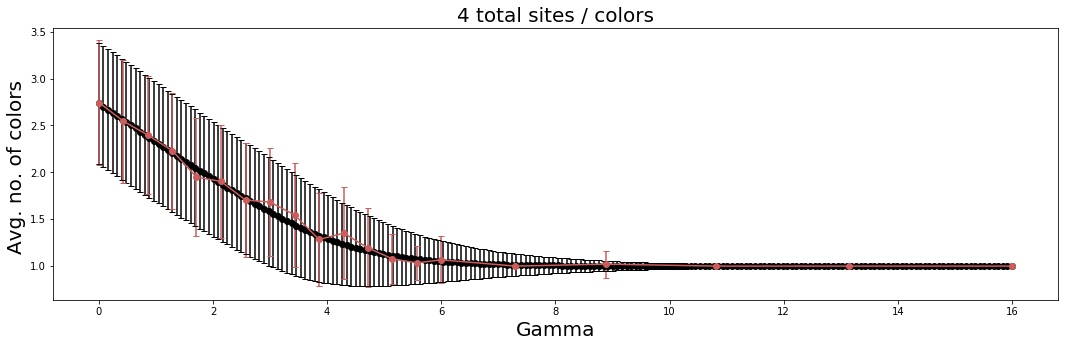

In [106]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
debugging  = True
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (2, 4, gammas=gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Initial configuration
[[1 9 6]
 [3 6 5]
 [5 6 1]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 1.2857142857142858
101 num. cols: 5.861386138613861 avg. sites per col: 1.5665134370579923
201 num. cols: 5.940298507462686 avg. sites per col: 1.550106609808103
301 num. cols: 5.960132890365449 avg. sites per col: 1.5442097769340302
401 num. cols: 5.975062344139651 avg. sites per col: 1.540639472746705
501 num. cols: 5.966067864271457 avg. sites per col: 1.5441402908468778
601 num. cols: 5.963394342762063 avg. sites per col: 1.5

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 1.8
101 num. cols: 4.1683168316831685 avg. sites per col: 2.3539603960396036
201 num. cols: 3.4378109452736316 avg. sites per col: 2.9679104477611937
301 num. cols: 3.495016611295681 avg. sites per col: 2.8619601328903634
401 num. cols: 3.5885286783042396 avg. sites per col: 2.744139650872815
501 num. cols: 3.662674650698603 avg. sites per col: 2.669076133447387
601 num. cols: 3.5607321131447587 avg. sites per col: 2.7748038982647922
701 num. cols: 3.5805991440798857 avg. sites per col: 2.736743427756262
801 num. cols: 3.606741573033708 avg. sites per col: 2.7010700909577268
901 num. cols: 3.645948945615982 avg. sites per col: 2.6646583161566526
1001 num. cols: 3.6003996003996006 avg. sites per col: 2.701006136720424
Final configuration:
[[1 2 3]
 [3 3 3]
 [3 3 3]]
Final averages: 3.5980099502487564 2.70219616204691
Final stds

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 3.0
101 num. cols: 2.1683168316831685 avg. sites per col: 4.2772277227722775
201 num. cols: 1.5870646766169154 avg. sites per col: 6.626865671641791
301 num. cols: 1.3953488372093024 avg. sites per col: 7.400332225913621
401 num. cols: 1.546134663341646 avg. sites per col: 6.677057356608479
501 num. cols: 1.6367265469061876 avg. sites per col: 6.24251497005988
601 num. cols: 1.838602329450915 avg. sites per col: 5.747920133111481
701 num. cols: 2.0042796005706136 avg. sites per col: 5.355920114122682
801 num. cols: 2.1048689138576777 avg. sites per col: 5.097378277153558
901 num. cols: 2.09322974472808 avg. sites per col: 5.031076581576027
1001 num. cols: 2.0839160839160837 avg. sites per col: 4.978021978021978
Final configuration:
[[1 2 2]
 [2 2 2]
 [2 2 2]]
Final averages: 2.083582089552239 4.976119402985074
Final stds: 0.69

801 num. cols: 1.0 avg. sites per col: 9.0
901 num. cols: 1.0 avg. sites per col: 9.0
1001 num. cols: 1.0 avg. sites per col: 9.0
Final configuration:
[[1 1 1]
 [1 1 1]
 [1 1 1]]
Final averages: 1.0 9.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - param: 16.0
lambda probabilities: [9.99999887e-01 1.12535162e-07 1.26641641e-14 1.42516392e-21
 1.60381071e-28 1.80485118e-35 2.03109243e-42 2.28569342e-49
 2.57220937e-56]
Initial configuration
[[5 9 6]
 [1 5 5]
 [9 7 4]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.0 avg. sites per col: 9.0
201 num. cols: 1.0 avg. sites per col: 9.0
301 num. cols: 1.0 avg. sites per col: 9.0
401 num. cols: 1.0 avg. sites per col: 9.0
501 num. cols: 1.0 avg. sites per col: 9.0
601 num. cols: 1.0 avg.

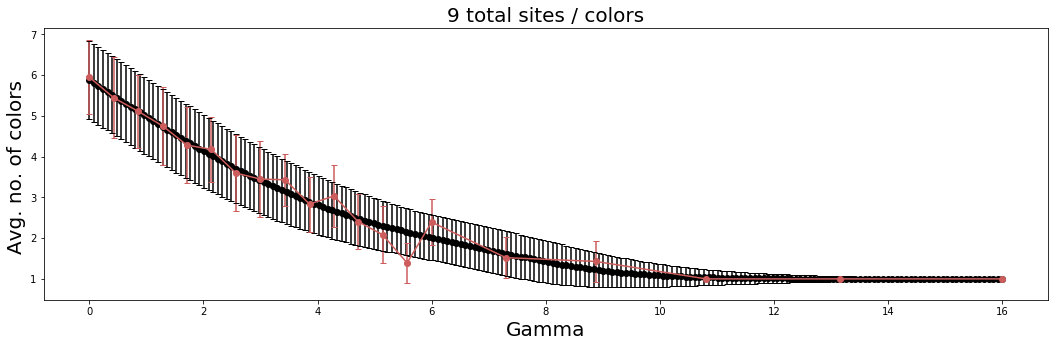

In [107]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
debugging  = True
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (3, 9, gammas=gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Initial configuration
[[14 14 13  9]
 [ 2 13 12  5]
 [ 8  5  9 13]
 [14  8 10  9]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 1.4545454545454546
101 num. cols: 10.316831683168317 avg. sites per col: 1.5690861393831672
201 num. cols: 10.303482587064677 avg. sites per col: 1.572786086218921
301 num. cols: 10.305647840531561 avg. sites per col: 1.5729588978758398
401 num. cols: 10.314214463840399 avg. sites per col: 1.5724797231031697
501 num. cols: 10.30538922

equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 8.0 avg. sites per col: 2.0
101 num. cols: 7.03960396039604 avg. sites per col: 2.305201948766302
201 num. cols: 6.885572139303482 avg. sites per col: 2.3636105188344
301 num. cols: 7.1096345514950166 avg. sites per col: 2.3028232011620764
401 num. cols: 7.132169576059851 avg. sites per col: 2.2885815763621338
501 num. cols: 6.922155688622754 avg. sites per col: 2.394741829472376
601 num. cols: 6.936772046589018 avg. sites per col: 2.3824755758200062
701 num. cols: 6.950071326676177 avg. sites per col: 2.3706014701735096
801 num. cols: 6.990012484394507 avg. sites per col: 2.355906487741693
901 num. cols: 7.022197558268591 avg. sites per col: 2.340857761057536
1001 num. cols: 7.053946053946054 avg. sites per col: 2.329412002139266
Final configuration:
[[1 2 3 4]
 [5 6 7 7]
 [7 7 7 7]
 [7 7 7 7]]
Final averages: 7.051741293532339 2.329996195070813
Final stds: 1.11404844287443

501 num. cols: 4.894211576846307 avg. sites per col: 3.3832905617336846
601 num. cols: 4.835274542429285 avg. sites per col: 3.414024245305454
701 num. cols: 4.855920114122682 avg. sites per col: 3.3857754228652785
801 num. cols: 4.6716604244694135 avg. sites per col: 3.56566197015635
901 num. cols: 4.513873473917869 avg. sites per col: 3.7319591987738594
1001 num. cols: 4.63036963036963 avg. sites per col: 3.646391703534555
Final configuration:
[[1 2 3 4]
 [5 6 6 6]
 [6 6 6 6]
 [6 6 6 6]]
Final averages: 4.635820895522388 3.642492300402742
Final stds: 1.0616379196313583 0.8690994633015182
------------------------------------------------------------------------------------------------------------------------

11  - param: 4.71
lambda probabilities: [9.90995222e-01 8.92369156e-03 8.03558577e-05 7.23586626e-07
 6.51573663e-09 5.86727592e-11 5.28335146e-13 4.75754048e-15
 4.28405939e-17 3.85770019e-19 3.47377322e-21 3.12805552e-23
 2.81674443e-25 2.53641571e-27 2.28398593e-29 2.07536675e-

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 2.0 avg. sites per col: 8.0
201 num. cols: 2.0 avg. sites per col: 8.0
301 num. cols: 2.0 avg. sites per col: 8.0
401 num. cols: 2.0 avg. sites per col: 8.0
501 num. cols: 2.0 avg. sites per col: 8.0
601 num. cols: 2.0 avg. sites per col: 8.0
701 num. cols: 2.0 avg. sites per col: 8.0
801 num. cols: 2.0 avg. sites per col: 8.0
901 num. cols: 2.0 avg. sites per col: 8.0
1001 num. cols: 2.042957042957043 avg. sites per col: 7.8854478854478725
Final configuration:
[[1 2 3 3]
 [3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]]
Final averages: 2.0467661691542287 7.875290215588709
Final stds: 0.21113761999432248 0.5630336533181933
------------------------------------------------------------------------------------------------------------------------

17  - param: 10.81
lambda probabilities: [9.99979803e-01 2.01961171e-05 4.07891382

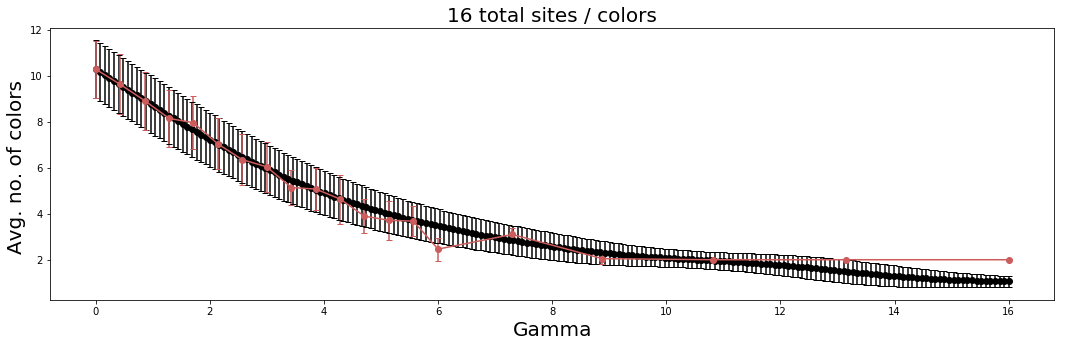

In [108]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
debugging  = True
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (4, 16, gammas=gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Initial configuration
[[ 8 10  2 22 16]
 [ 8  4 21  7 20]
 [ 3 10  1 14 10]
 [ 4  1 21 12 19]
 [17 15  6  9 15]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 15.0 avg. sites per col: 1.6666666666666667
101 num. cols: 16.128712871287128 avg. sites per col: 1.563028442894641
201 num. cols: 16.104477611940297 avg. sites per col: 1.5684146801441528
301 num. cols: 16.023255813953487 avg. sites per col: 1.57

401 num. cols: 12.094763092269327 avg. sites per col: 2.1024804962937567
501 num. cols: 12.165668662674651 avg. sites per col: 2.0869613228278263
601 num. cols: 12.104825291181365 avg. sites per col: 2.0970035627591614
701 num. cols: 11.837375178316691 avg. sites per col: 2.149238455827778
801 num. cols: 11.957553058676654 avg. sites per col: 2.1278234909403597
901 num. cols: 11.81354051054384 avg. sites per col: 2.155219952785558
1001 num. cols: 11.917082917082917 avg. sites per col: 2.135114333522541
Final configuration:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 12 12 12]
 [12 12 12 12 12]
 [12 12 12 12 12]]
Final averages: 11.917412935323384 2.13490823998945
Final stds: 1.5683896338011059 0.2858567046471276
------------------------------------------------------------------------------------------------------------------------

5  - param: 2.14
lambda probabilities: [8.82345157e-01 1.03812181e-01 1.22140059e-02 1.43703694e-03
 1.69074356e-04 1.98924168e-05 2.34043917e-06 2.75364004

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 2.7777777777777777
101 num. cols: 8.257425742574258 avg. sites per col: 3.0376787678767876
201 num. cols: 8.228855721393035 avg. sites per col: 3.049040511727078
301 num. cols: 8.813953488372093 avg. sites per col: 2.8739468357408597
401 num. cols: 8.765586034912719 avg. sites per col: 2.8847733383269625
501 num. cols: 8.47305389221557 avg. sites per col: 2.997771246274258
601 num. cols: 8.194675540765392 avg. sites per col: 3.113277575632015
701 num. cols: 8.049928673323823 avg. sites per col: 3.167171135252471
801 num. cols: 8.00374531835206 avg. sites per col: 3.1797411736550467
901 num. cols: 7.739178690344062 avg. sites per col: 3.3343996766582884
1001 num. cols: 7.62037962037962 avg. sites per col: 3.4037970576432177
Final configuration:
[[1 2 3 4 5]
 [6 7 8 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]]
Final averages: 7.

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 4.0 avg. sites per col: 6.25
201 num. cols: 4.0 avg. sites per col: 6.25
301 num. cols: 4.0 avg. sites per col: 6.25
401 num. cols: 4.107231920199501 avg. sites per col: 6.115960099750623
501 num. cols: 4.285429141716567 avg. sites per col: 5.893213572854291
601 num. cols: 4.404326123128119 avg. sites per col: 5.74459234608985
701 num. cols: 4.489300998573467 avg. sites per col: 5.638373751783167
801 num. cols: 4.5530586766541825 avg. sites per col: 5.558676654182272
901 num. cols: 4.602663706992231 avg. sites per col: 5.496670366259711
1001 num. cols: 4.642357642357642 avg. sites per col: 5.447052947052947
Final configuration:
[[1 2 3 4 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]]
Final averages: 4.643781094527363 5.445273631840796
Final stds: 0.4788809840205742 0.5986012300257177
--------------

801 num. cols: 4.0 avg. sites per col: 6.25
901 num. cols: 4.0 avg. sites per col: 6.25
1001 num. cols: 4.0 avg. sites per col: 6.25
Final configuration:
[[1 2 3 4 4]
 [4 4 4 4 4]
 [4 4 4 4 4]
 [4 4 4 4 4]
 [4 4 4 4 4]]
Final averages: 4.0 6.25
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------



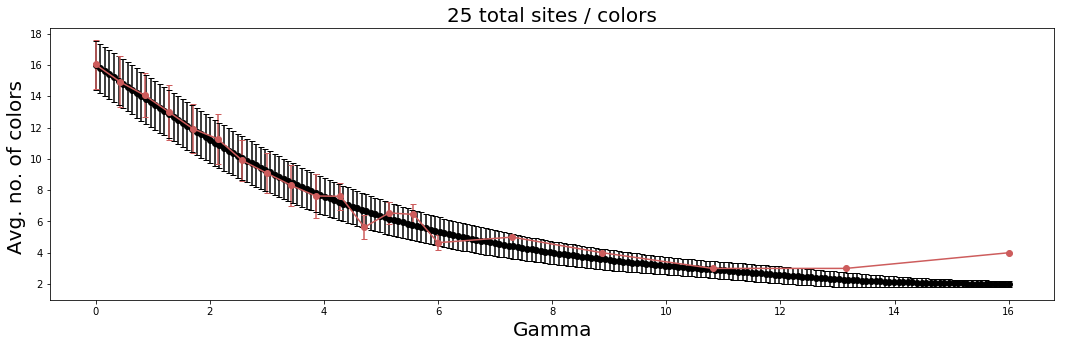

In [109]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
debugging  = True
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (5, 25, gammas=gammas, J=0, alpha=0)

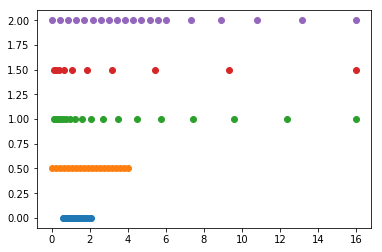

In [100]:
import matplotlib.pyplot as plt
N = 20
y = np.zeros(N)
x1 = np.logspace(-3,4, base=1.2, num=N).round(decimals=2)
x2 = (np.linspace(0, 4, num=N)**1).round(decimals=2)
x3 = np.geomspace(0.125, 16, num=N).round(decimals=2)
x4 = np.logspace(-3,4, base=2, num=N-10).round(decimals=2)
x5 = np.linspace(0, 6, num=N-6, endpoint=False)
x5 = np.append(x5, np.geomspace(6, 16, num=6)).round(decimals=2)

plt.plot(x1, y, 'o')
plt.plot(x2, y + 0.5, 'o')
plt.plot(x3, y + 1, 'o')
plt.plot(x4, np.zeros(10) + 1.5, 'o')
plt.plot(x5, y + 2, 'o')

plt.show()